In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from geopy.distance import geodesic

# Set up visualization style
# Set up visualization (corrected)
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')  # Or any style from plt.style.available
sns.set_theme(style="whitegrid")  # Proper seaborn theming
%matplotlib inline

In [2]:
def load_and_clean_data(path):
    """Load and clean the raw Zomato dataset"""
    try:
        df = pd.read_csv(r"C:\Users\user\Desktop\zomato.csv", encoding='latin1')
        
        # Remove unnecessary columns
        cols_to_drop = ['URL', 'Address', 'Phone', 'Locality Verbose', 
                      'Switch to order menu', 'Rating color', 'Rating text']
        df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')
        
        # Handle missing values
        df['Cuisines'] = df['Cuisines'].fillna('Unknown')
        df['Aggregate rating'] = df['Aggregate rating'].fillna(0)
        df['Votes'] = df['Votes'].fillna(0)
        
        return df
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return pd.DataFrame()

# Load the data
df = load_and_clean_data('zomato.csv')
df.head()

,Restaurant ID,Restaurant Name,Country Code,City,Locality,Longitude,Latitude,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Century City Mall, Poblacion, Makati City",121.027535,14.565443,"French, Japanese, Desserts",1100,Botswana Pula(P),Yes,No,No,3,4.8,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, Legaspi Village, Makati City",121.014101,14.553708,Japanese,1200,Botswana Pula(P),Yes,No,No,3,4.5,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, Ortigas, Mandaluyong City",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",4000,Botswana Pula(P),Yes,No,No,4,4.4,270
3,6318506,Ooma,162,Mandaluyong City,"SM Megamall, Ortigas, Mandaluyong City",121.056475,14.585318,"Japanese, Sushi",1500,Botswana Pula(P),No,No,No,4,4.9,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"SM Megamall, Ortigas, Mandaluyong City",121.057508,14.584450,"Japanese, Korean",1500,Botswana Pula(P),Yes,No,No,4,4.8,229


In [3]:
def preprocess_data(df):
    """Preprocess the cleaned dataset"""
    # Make a copy to avoid SettingWithCopyWarning
    processed_df = df.copy()
    
    # Standardize formats
    processed_df['Cuisines'] = processed_df['Cuisines'].str.lower().str.strip()
    processed_df['Currency'] = processed_df['Currency'].str.upper()
    
    # Extract primary cuisine
    processed_df['Primary Cuisine'] = processed_df['Cuisines'].str.split(',').str[0].str.strip()
    
    # Cost categorization with currency conversion
    def categorize_cost(row):
        cost = row['Average Cost for two']
        currency = row['Currency']
        
        if pd.isna(cost):
            return 'Unknown'
            
        # Convert to USD equivalent for standardization
        if currency == 'INR':
            usd_equivalent = cost / 75
        elif currency == 'EUR':
            usd_equivalent = cost * 1.1
        else:  # Assume USD
            usd_equivalent = cost
            
        if usd_equivalent < 15: return 'Low'
        elif usd_equivalent < 30: return 'Medium'
        else: return 'High'
        
    processed_df['Cost Category'] = processed_df.apply(categorize_cost, axis=1)
    
    # Calculate popularity score
    max_votes = processed_df['Votes'].max()
    processed_df['Popularity'] = processed_df['Votes'] / max_votes if max_votes > 0 else 0
    
    return processed_df

# Preprocess the data
processed_df = preprocess_data(df)
processed_df.head()

,Restaurant ID,Restaurant Name,Country Code,City,Locality,Longitude,Latitude,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Votes,Primary Cuisine,Cost Category,Popularity
0,6317637,Le Petit Souffle,162,Makati City,"Century City Mall, Poblacion, Makati City",121.027535,14.565443,"french, japanese, desserts",1100,BOTSWANA PULA(P),Yes,No,No,3,4.8,314,french,High,0.028718
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, Legaspi Village, Makati City",121.014101,14.553708,japanese,1200,BOTSWANA PULA(P),Yes,No,No,3,4.5,591,japanese,High,0.054052
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, Ortigas, Mandaluyong City",121.056831,14.581404,"seafood, asian, filipino, indian",4000,BOTSWANA PULA(P),Yes,No,No,4,4.4,270,seafood,High,0.024694
3,6318506,Ooma,162,Mandaluyong City,"SM Megamall, Ortigas, Mandaluyong City",121.056475,14.585318,"japanese, sushi",1500,BOTSWANA PULA(P),No,No,No,4,4.9,365,japanese,High,0.033382
4,6314302,Sambo Kojin,162,Mandaluyong City,"SM Megamall, Ortigas, Mandaluyong City",121.057508,14.584450,"japanese, korean",1500,BOTSWANA PULA(P),Yes,No,No,4,4.8,229,japanese,High,0.020944


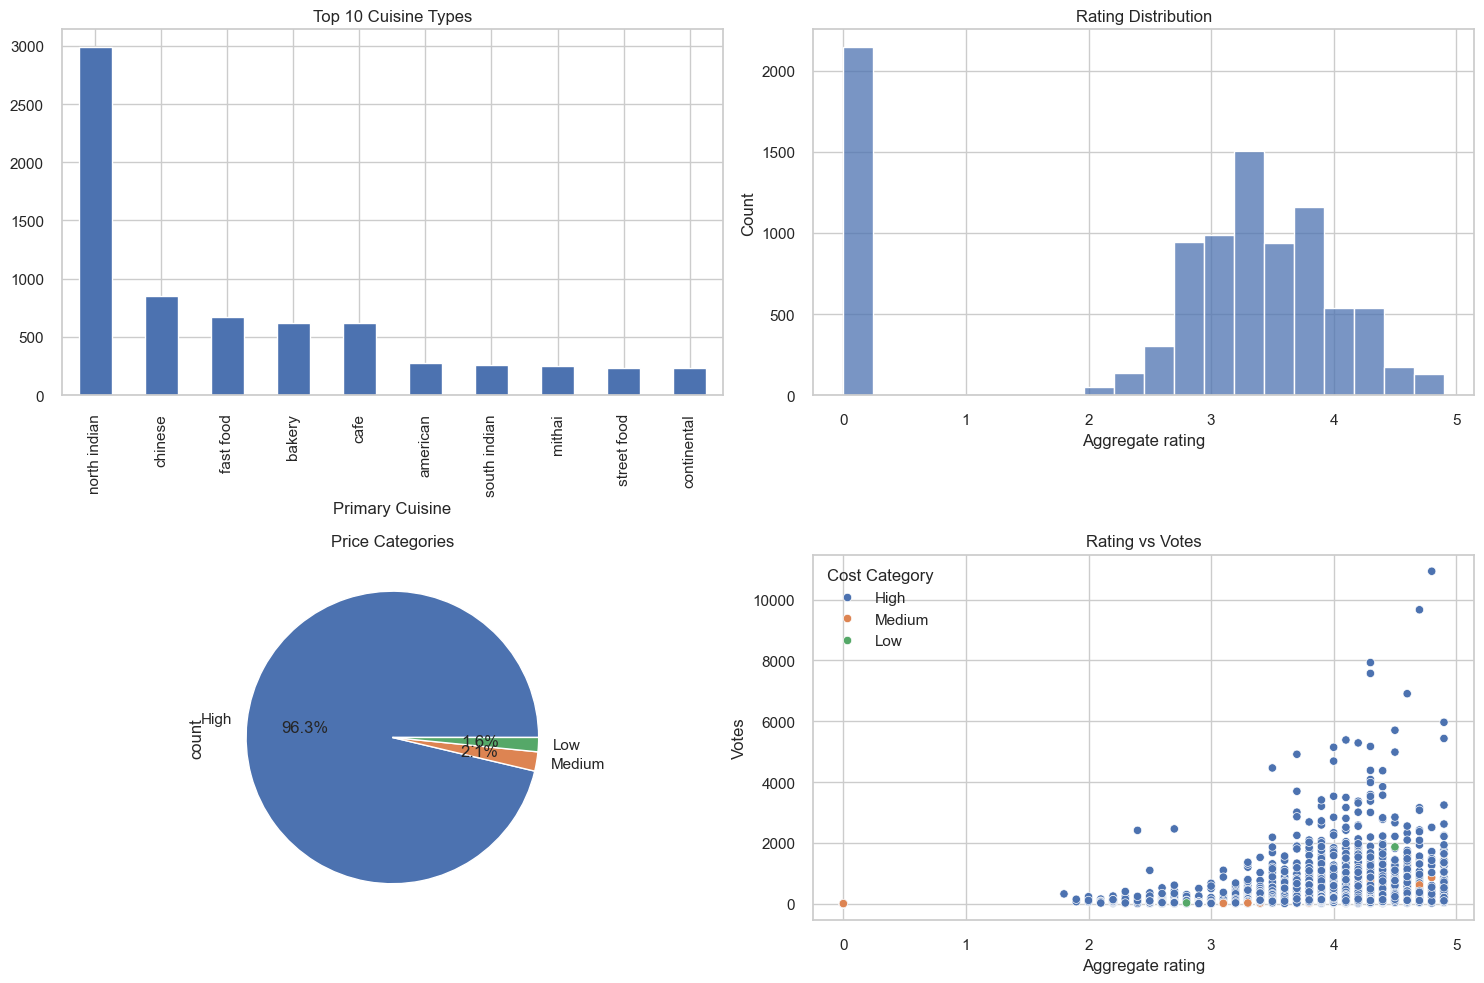

In [4]:
def visualize_data(df):
    """Generate exploratory data visualizations"""
    plt.figure(figsize=(15, 10))
    
    # Cuisine distribution
    plt.subplot(2, 2, 1)
    df['Primary Cuisine'].value_counts().head(10).plot(kind='bar')
    plt.title('Top 10 Cuisine Types')
    
    # Rating distribution
    plt.subplot(2, 2, 2)
    sns.histplot(df['Aggregate rating'], bins=20)
    plt.title('Rating Distribution')
    
    # Cost distribution
    plt.subplot(2, 2, 3)
    df['Cost Category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Price Categories')
    
    # Votes vs Rating
    plt.subplot(2, 2, 4)
    sns.scatterplot(data=df, x='Aggregate rating', y='Votes', hue='Cost Category')
    plt.title('Rating vs Votes')
    
    plt.tight_layout()
    plt.savefig('data_visualization.png')
    plt.show()

# Generate visualizations
visualize_data(processed_df)

In [5]:
class RestaurantRecommender:
    def __init__(self, df):
        self.df = df
        
    def recommend(self, user_prefs, max_results=10):
        """Generate restaurant recommendations based on user preferences"""
        filtered = self.df.copy()
        
        # Exact location matching
        if 'location' in user_prefs and user_prefs['location']:
            loc = user_prefs['location'].lower().strip()
            filtered = filtered[
                (filtered['Locality'].str.lower() == loc) | 
                (filtered['City'].str.lower() == loc)
            ]
        
        # Cuisine filter
        if 'cuisines' in user_prefs and user_prefs['cuisines']:
            cuisines = [c.lower().strip() for c in user_prefs['cuisines']]
            filtered = filtered[filtered['Cuisines'].apply(lambda x: any(c in x for c in cuisines))]
        
        # Budget filter
        if 'budget' in user_prefs and user_prefs['budget']:
            filtered = filtered[filtered['Cost Category'] == user_prefs['budget']]
        
        # Rating filter
        if 'min_rating' in user_prefs:
            filtered = filtered[filtered['Aggregate rating'] >= user_prefs['min_rating']]
        
        # Proximity filter (if coordinates provided)
        if 'user_lat' in user_prefs and 'user_lon' in user_prefs:
            filtered['Distance'] = filtered.apply(
                lambda row: geodesic(
                    (user_prefs['user_lat'], user_prefs['user_lon']),
                    (row['Latitude'], row['Longitude'])
                ).km if not pd.isna(row['Latitude']) else np.inf,
                axis=1
            )
            filtered = filtered.sort_values('Distance')
        
        # Calculate final score
        filtered['Score'] = (0.6 * filtered['Aggregate rating']/5 + 
                           0.3 * filtered['Popularity'] + 
                           0.1 * (1 - filtered.get('Distance', 0)/filtered.get('Distance', 1).max()))
        
        # Sort and format results
        results = filtered.sort_values('Score', ascending=False).head(max_results)
        results['Explanation'] = results.apply(
            lambda row: (
                f"Top match for {user_prefs.get('cuisines',['any'])[0]} "
                f"({row['Cost Category']} price, {row['Distance']:.1f}km away) "
                f"with {row['Aggregate rating']}/5 rating from {row['Votes']} votes"
            ),
            axis=1
        )
        
        return results

# Initialize recommender
recommender = RestaurantRecommender(processed_df)

In [6]:
# Save cleaned data
processed_df.to_csv('cleaned_zomato.csv', index=False)

# Save trained model
joblib.dump(recommender, 'restaurant_recommender_model.joblib')

print("Data and model saved successfully!")

Data and model saved successfully!


In [7]:
# Example user preferences
user_prefs = {
    'location': 'Connaught Place',
    'cuisines': ['Italian', 'Mediterranean'],
    'budget': 'High',
    'min_rating': 4.0,
    'user_lat': 28.63,
    'user_lon': 77.22
}

# Get recommendations
recommendations = recommender.recommend(user_prefs)

# Display results
print(f"Found {len(recommendations)} recommendations:")
recommendations[['Restaurant Name', 'Locality', 'Primary Cuisine', 
                'Cost Category', 'Aggregate rating', 'Distance', 'Explanation']]

Found 10 recommendations:


,Restaurant Name,Locality,Primary Cuisine,Cost Category,Aggregate rating,Distance,Explanation
3094,Ardor 2.1,Connaught Place,north indian,High,4.1,0.017358,"Top match for Italian (High price, 0.0km away)..."
3115,The Town House Cafe,Connaught Place,continental,High,4.0,0.053170,"Top match for Italian (High price, 0.1km away)..."
3108,Pebble Street,Connaught Place,italian,High,4.0,0.050907,"Top match for Italian (High price, 0.1km away)..."
3099,Excuse Me Boss,Connaught Place,continental,High,4.1,0.134221,"Top match for Italian (High price, 0.1km away)..."
3116,United Coffee House,Connaught Place,north indian,High,4.1,0.299874,"Top match for Italian (High price, 0.3km away)..."
3012,MOB Brewpub,Connaught Place,continental,High,4.7,0.445582,"Top match for Italian (High price, 0.4km away)..."
3104,HotMess,Connaught Place,north indian,High,4.3,0.366681,"Top match for Italian (High price, 0.4km away)..."
3092,38 Barracks,Connaught Place,north indian,High,4.4,0.436482,"Top match for Italian (High price, 0.4km away)..."
3093,Ambrosia Bliss,Connaught Place,north indian,High,4.0,0.476254,"Top match for Italian (High price, 0.5km away)..."
3120,{Niche} - Cafe & Bar,Connaught Place,north indian,High,4.1,0.297202,"Top match for Italian (High price, 0.3km away)..."
